# Coursework 2: Image segmentation

In this coursework you will develop and train a convolutional neural network for brain tumour segmentation. Please read both the text and the code in this notebook to get an idea what you are expected to implement. Pay attention to the missing code blocks that look like this:

```
### Insert your code ###
...
### End of your code ###
```
## What is expected?

* Complete and run the code using `jupyter-lab`.

* Export (File | Save and Export Notebook As...) the notebook as a PDF file, which contains your code, results and answers, and upload the PDF file onto [Scientia](https://scientia.doc.ic.ac.uk).

* If Jupyter complains issues during exporting, it is likely that [pandoc](https://pandoc.org/installing.html) or latex is not installed, or their paths have not been included. You can install the relevant libraries and retry. Alternatively, use the Print function of your browser to export the PDF file.

* If Jupyter-lab does not work for you at the end, alternatively, you can use Google Colab to write the code and export the PDF file.

## Dependencies

You need to install Jupyter-Lab (https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html) and other libraries used in this coursework, such as by running the command:
`pip3 install [package_name]`

## GPU resource

The coursework is developed to be able to run on CPU, as all images have been pre-processed to be 2D and of a smaller size, compared to original 3D volumes.

However, to save training time, you may want to use GPU. In that case, you can run this notebook on Google Colab. On Google Colab, go to the menu, Runtime - Change runtime type, and select **GPU** as the hardware acceleartor. At the end, please still export everything and submit as a PDF file on Scientia.


In [6]:
# Import libraries
# These libraries should be sufficient for this tutorial.
# However, if any other library is needed, please install by yourself.
import tarfile
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
import numpy as np
import time
import os
import random
import matplotlib.pyplot as plt
from matplotlib import colors

## Q1. Download and visualise the imaging dataset.

The dataset is a public brain imaging dataset from [Medical Decathlon Challenge](http://medicaldecathlon.com/). To save the storage and reduce the computational cost for this tutorial, we extract 2D image slices from the original 3D volumes (T1-Gd contrast enhanced imaging) and downsample the 2D images.

The dataset consists of a training set and a test set. Each image is of dimension 120 x 120, with a corresponding label map of the same dimension. There are four number of classes in the label map:

- 0: background
- 1: edema
- 2: non-enhancing tumour
- 3: enhancing tumour

In [2]:
# Download the dataset
# If you use Ubuntu, wget would natively work.
# If you use Mac or Windows, which does not have the wget command, you can copy the URL to the web browser and download the file.
!wget https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz

# Unzip the '.tar.gz' file to the current directory
datafile = tarfile.open('Task01_BrainTumour_2D.tar.gz')
datafile.extractall()
datafile.close()

--2026-02-09 22:23:42--  https://www.dropbox.com/s/zmytk2yu284af6t/Task01_BrainTumour_2D.tar.gz
Resolving www.dropbox.com (www.dropbox.com)... 2620:100:6020:18::a27d:4012, 162.125.64.18
Connecting to www.dropbox.com (www.dropbox.com)|2620:100:6020:18::a27d:4012|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1 [following]
--2026-02-09 22:23:43--  https://www.dropbox.com/scl/fi/4bf8fqcfgf3lebiv2in99/Task01_BrainTumour_2D.tar.gz?rlkey=ceq898g2tr3aaxjxn4xjxbob1
Reusing existing connection to [www.dropbox.com]:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc150e32fc7d4c4e4736c8c8fac8.dl.dropboxusercontent.com/cd/0/inline/C6mS1k_CJYOXfKPkF3St4Ci4IYZFtaOZd8KiklOuEx3uTaeD7VCLt5_GdetuHJbqjv-tl-NHcXt9nwYlPEHVBP2anPKlu_sk2cvHo5KGnzamqSl1Qv8uJ-FSih6SJKvLaJ0/file# [following]
--2026-02-09 22:23:43--  https://uc150e32fc7d4c4e4736c8

## Visualise a random set of 4 training images along with their label maps.

Suggested colour map for brain MR image:
```
cmap = 'gray'
```

Suggested colour map for segmentation map:
```
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])
```

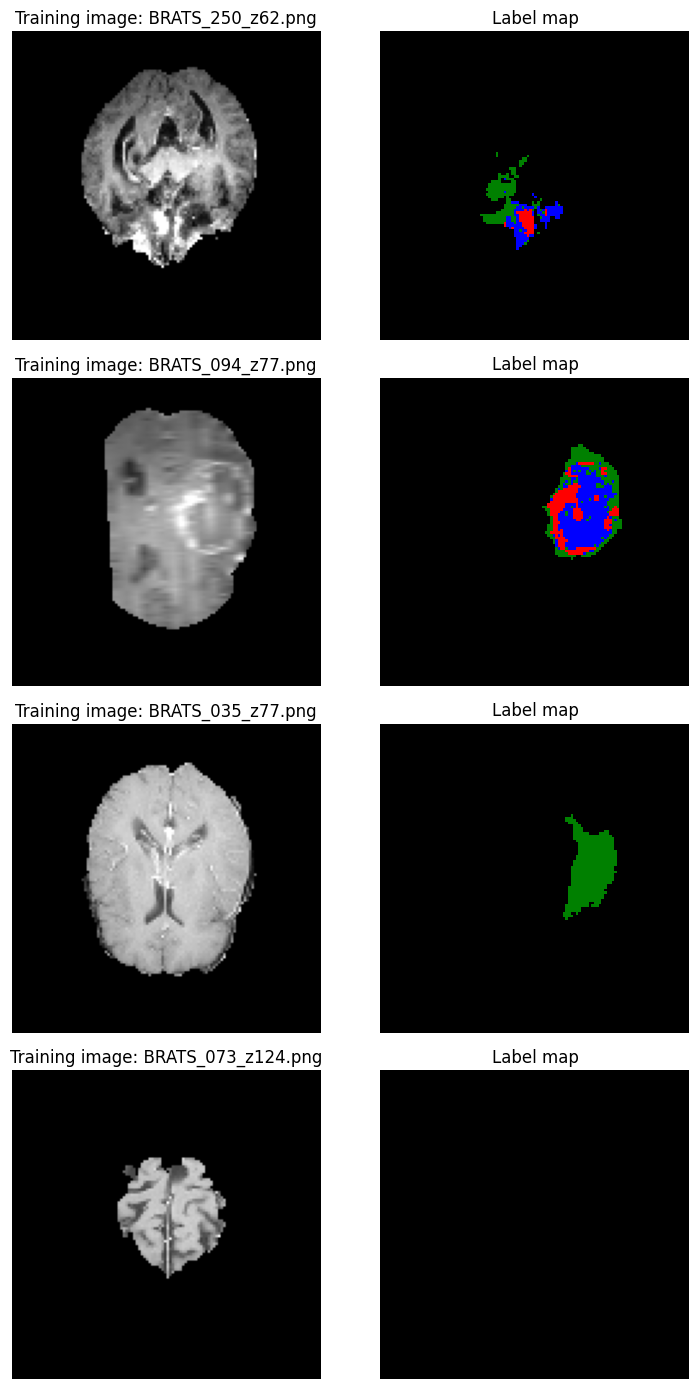

In [5]:
### Insert your code ###
train_img_dir = 'Task01_BrainTumour_2D/training_images'
train_lbl_dir = 'Task01_BrainTumour_2D/training_labels'

file_names = os.listdir(train_img_dir)
chosen = random.sample(file_names, 4)

cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

fig, ax = plt.subplots(4, 2, figsize=(8, 14))

for i, name in enumerate(chosen):
    img = imageio.v2.imread(os.path.join(train_img_dir, name))
    lbl = imageio.v2.imread(os.path.join(train_lbl_dir, name))

    ax[i, 0].imshow(img, cmap='gray')
    ax[i, 0].set_title(f'Training image: {name}')
    ax[i, 0].axis('off')

    ax[i, 1].imshow(lbl, cmap=cmap, vmin=0, vmax=3, interpolation='nearest')
    ax[i, 1].set_title('Label map')
    ax[i, 1].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## Q2. Implement a dataset class.

It can read the imaging dataset and get items, pairs of images and label maps, to be used as training batches.

In [7]:
def normalise_intensity(image, thres_roi=1.0):
    """ Normalise the image intensity by the mean and standard deviation """
    # ROI defines the image foreground
    val_l = np.percentile(image, thres_roi)
    roi = (image >= val_l)
    mu, sigma = np.mean(image[roi]), np.std(image[roi])
    eps = 1e-6
    image2 = (image - mu) / (sigma + eps)
    return image2


class BrainImageSet(Dataset):
    """ Brain image set """
    def __init__(self, image_path, label_path='', deploy=False):
        self.image_path = image_path
        self.deploy = deploy
        self.images = []
        self.labels = []

        image_names = sorted(os.listdir(image_path))
        for image_name in image_names:
            # Read the image
            image = imageio.v2.imread(os.path.join(image_path, image_name))
            self.images += [image]

            # Read the label map
            if not self.deploy:
                label_name = os.path.join(label_path, image_name)
                label = imageio.v2.imread(label_name)
                self.labels += [label]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get an image and perform intensity normalisation
        # Dimension: XY
        image = normalise_intensity(self.images[idx])

        # Get its label map
        # Dimension: XY
        label = self.labels[idx]
        return image, label

    def get_random_batch(self, batch_size):
        # Get a batch of paired images and label maps
        # Dimension of images: NCXY
        # Dimension of labels: NXY
        images, labels = [], []

        ### Insert your code ###
        indices = np.random.choice(len(self), size=batch_size, replace=False)
        for idx in indices:
            img, lbl = self[idx]
            images.append(img[np.newaxis, ...])
            labels.append(lbl)

        images = np.stack(images, axis=0).astype(np.float32)
        labels = np.stack(labels, axis=0).astype(np.int64)
        ### End of your code ###
        return images, labels

## Q3. Build a U-net architecture.

Implement a U-net architecture for image segmentation. If you are not familiar with U-net, you can read this paper:

[1] Olaf Ronneberger et al. [U-Net: Convolutional networks for biomedical image segmentation](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28). MICCAI, 2015.

For the first convolutional layer, you can start with 16 filters. We have implemented the encoder path. Please complete the decoder path.

In [ ]:
""" U-net """
class UNet(nn.Module):
    def __init__(self, input_channel=1, output_channel=1, num_filter=16):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels, stride=1):
            """Create a convolutional block with two conv layers"""
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU()
            )
        
        # BatchNorm: by default during training this layer keeps running estimates
        # of its computed mean and variance, which are then used for normalization
        # during evaluation.

        # Encoder path
        self.conv1 = conv_block(input_channel, num_filter) # 16 filters
        self.conv2 = conv_block(num_filter, num_filter * 2, stride=2) # 32 filters
        self.conv3 = conv_block(num_filter * 2, num_filter * 4, stride=2) # 64 filters
        self.conv4 = conv_block(num_filter * 4, num_filter * 8, stride=2) # 128 filters

        # Bridge
        self.conv5 = conv_block(num_filter * 8, num_filter * 16, stride=2) # 256 filters
        
        # Decoder path
        self.up4 = nn.ConvTranspose2d(num_filter * 16, num_filter * 8, kernel_size=3, stride=2, padding=1)
        self.conv4_up = conv_block(num_filter * 16, num_filter * 8) # concatenate conv4 with up4

        self.up3 = nn.ConvTranspose2d(num_filter * 8, num_filter * 4, kernel_size=3, stride=2, padding=1)
        self.conv3_up = conv_block(num_filter * 8, num_filter * 4) # concatenate conv3 with up3

        self.up2 = nn.ConvTranspose2d(num_filter * 4, num_filter * 2, kernel_size=3, stride=2, padding=1)
        self.conv2_up = conv_block(num_filter * 4, num_filter * 2) # concatenate conv2 with up2

        self.up1 = nn.ConvTranspose2d(num_filter * 2, num_filter, kernel_size=3, stride=2, padding=1)
        self.conv1_up = conv_block(num_filter * 2, num_filter ) # concatenate conv1 with up1

        # Final output layer
        self.out = nn.Conv2d(num_filter, output_channel, kernel_size=1)


    def forward(self, x):
        # Use the convolutional operators defined above to build the U-net
        # The encoder part is already done for you.
        # You need to complete the decoder part.
        # Encoder
        x = self.conv1(x)
        conv1_skip = x

        x = self.conv2(x)
        conv2_skip = x

        x = self.conv3(x)
        conv3_skip = x

        x = self.conv4(x)
        conv4_skip = x

        x = self.conv5(x)

        # Decoder
        ### Insert your code ###
        x = self.up4(x)
        x = torch.cat([x, conv4_skip], dim=1)
        x = self.conv4_up(x)

        x = self.up3(x)
        x = torch.cat([x, conv3_skip], dim=1)
        x = self.conv3_up(x)

        x = self.up2(x)
        x = torch.cat([x, conv2_skip], dim=1)
        x = self.conv2_up(x)

        x = self.up1(x)
        x = torch.cat([x, conv1_skip], dim=1)
        x = self.conv1_up(x)
        ### End of your code ###
        return x

## Q4. Train the segmentation model.

In [ ]:
# CUDA device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device: {0}'.format(device))

# Build the model
num_class = 4
model = UNet(input_channel=1, output_channel=num_class, num_filter=16)
model = model.to(device)
params = list(model.parameters())

model_dir = 'saved_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# Optimizer
optimizer = optim.Adam(params, lr=1e-3)

# Segmentation loss
criterion = nn.CrossEntropyLoss()

# Datasets
train_set = BrainImageSet('Task01_BrainTumour_2D/training_images', 'Task01_BrainTumour_2D/training_labels')
test_set = BrainImageSet('Task01_BrainTumour_2D/test_images', 'Task01_BrainTumour_2D/test_labels')

# Train the model
# Note: when you debug the model, you may reduce the number of iterations or batch size to save time.
num_iter = 10000
train_batch_size = 16
eval_batch_size = 16
start = time.time()

def process_batch(dataset, batch_size):
    images, labels = dataset.get_random_batch(batch_size)
    images, labels = torch.from_numpy(images), torch.from_numpy(labels)
    images, labels = images.to(device, dtype=torch.float32), labels.to(device, dtype=torch.long)
    return images, labels

for it in range(1, 1 + num_iter):
    # Set the modules in training mode, which will have effects on certain modules, e.g. dropout or batchnorm.
    start_iter = time.time()
    model.train()

    # Get a batch of images and labels
    images, labels = process_batch(train_set, train_batch_size)
    logits = model(images)

    # Perform optimisation and print out the training loss
    ### Insert your code ###
    optimizer.zero_grad()
    loss = criterion(logits, labels)
    loss.backward()
    optimizer.step()
    print(f"Iteration {it}/{num_iter}, Training Loss: {loss.item():.4f}")
    ### End of your code ###

    # Evaluate
    if it % 1000 == 0:
        model.eval()
        # Disabling gradient calculation during reference to reduce memory consumption
        with torch.no_grad():
            # Evaluate on a batch of test images and print out the test loss
            ### Insert your code ###
            test_images, test_labels = process_batch(test_set, eval_batch_size)
            test_logits = model(test_images)
            test_loss = criterion(test_logits, test_labels)
            print(f"Eval Loss: {test_loss.item():.4f}")
            ### End of your code ###

    # Save the model
    if it % 5000 == 0:
        torch.save(model.state_dict(), os.path.join(model_dir, 'model_{0}.pt'.format(it)))
print('Training took {:.3f}s in total.'.format(time.time() - start))

## Q5. Deploy the trained model to a random set of 4 test images and visualise the automated segmentation.

You can show the images as a 4 x 3 panel. Each row shows one example, with the 3 columns being the test image, automated segmentation and ground truth segmentation.

In [ ]:
### Insert your code ###
# Set model to evaluation mode
model.eval()

# Get 4 random test images
test_img_dir = 'Task01_BrainTumour_2D/test_images'
test_lbl_dir = 'Task01_BrainTumour_2D/test_labels'

file_names = os.listdir(test_img_dir)
chosen = random.sample(file_names, 4)

# Color map for segmentation
cmap = colors.ListedColormap(['black', 'green', 'blue', 'red'])

# Create 4x3 panel
fig, ax = plt.subplots(4, 3, figsize=(12, 14))

with torch.no_grad():
    for i, name in enumerate(chosen):
        # Load test image and label
        img = imageio.v2.imread(os.path.join(test_img_dir, name))
        lbl = imageio.v2.imread(os.path.join(test_lbl_dir, name))
        
        # Normalize and prepare image for model
        img_normalized = normalise_intensity(img)
        img_tensor = torch.from_numpy(img_normalized[np.newaxis, np.newaxis, ...]).to(device, dtype=torch.float32)
        
        # Get model prediction
        logits = model(img_tensor)
        pred = torch.argmax(logits, dim=1).cpu().numpy()[0]
        
        # Display test image
        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 0].set_title(f'Test Image: {name}')
        ax[i, 0].axis('off')
        
        # Display automated segmentation
        ax[i, 1].imshow(pred, cmap=cmap, vmin=0, vmax=3, interpolation='nearest')
        ax[i, 1].set_title('Automated Segmentation')
        ax[i, 1].axis('off')
        
        # Display ground truth segmentation
        ax[i, 2].imshow(lbl, cmap=cmap, vmin=0, vmax=3, interpolation='nearest')
        ax[i, 2].set_title('Ground Truth')
        ax[i, 2].axis('off')

plt.tight_layout()
plt.show()
### End of your code ###

## Q6. Discussion. Does your trained model work well? How would you improve this model so it can be deployed to the real clinic?